In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np

# Load Data

In [2]:
filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


embedding_dim 512
n_proteins 19699
precision 16


# Combine Data

In [55]:
# First create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Calculate frequency of each GO term (counting once per protein)
term_frequencies = {}
total_proteins = len(go_descriptions)
for terms in go_descriptions:
    unique_terms = set(terms)
    for term in unique_terms:
        term_frequencies[term] = term_frequencies.get(term, 0) + 1

# Convert to percentages
term_percentages = {term: count/total_proteins for term, count in term_frequencies.items()}

# Find terms that appear in more than 5% of proteins
common_terms = {term for term, percentage in term_percentages.items() if percentage > 0.005}

# Filter out common terms
def filter_common_terms(terms):
    return [term for term in terms if term not in common_terms]

# Apply filtering
filtered_go_descriptions = go_descriptions.apply(filter_common_terms)

# Create binary vectors for remaining terms
all_go_terms = sorted(set(term for terms in filtered_go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in filtered_go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(filtered_go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

# Print summary statistics
print("Dataset Statistics:")
print(f"Total number of proteins: {len(final_df)}")
print(f"Total number of GO terms after filtering: {len(all_go_terms)}")
print(f"Number of common terms filtered out (>5%): {len(common_terms)}")

# Calculate how many proteins have no terms
empty_vectors = sum(1 for vec in final_df['go_vector'] if sum(vec) == 0)
print(f"\nProteins with no GO terms: {empty_vectors} ({(empty_vectors/len(final_df))*100:.1f}%)")
print(f"- From missing GO annotations: {len(network_vector_df.index) - len(go_descriptions)}")
print(f"- From filtering: {empty_vectors - (len(network_vector_df.index) - len(go_descriptions))}")

# Calculate distribution of GO terms per protein
terms_per_protein = [sum(vec) for vec in final_df['go_vector']]
print("\nGO terms per protein distribution:")
print(f"Mean: {np.mean(terms_per_protein):.1f}")
print(f"Median: {np.median(terms_per_protein):.1f}")
print(f"Min: {min(terms_per_protein)}")
print(f"Max: {max(terms_per_protein)}")

# Calculate most common remaining terms
term_counts = np.sum([vec for vec in final_df['go_vector']], axis=0)
top_terms_idx = np.argsort(term_counts)[-5:][::-1]
print("\nTop 5 most common remaining terms:")
for idx in top_terms_idx:
    term = [k for k, v in term_to_idx.items() if v == idx][0]
    count = term_counts[idx]
    percentage = (count/len(final_df))*100
    print(f"{term}: {count} proteins ({percentage:.1f}%)")

Dataset Statistics:
Total number of proteins: 19699
Total number of GO terms after filtering: 13889
Number of common terms filtered out (>5%): 1798

Proteins with no GO terms: 6466 (32.8%)
- From missing GO annotations: 2434
- From filtering: 4032

GO terms per protein distribution:
Mean: 8.7
Median: 3.0
Min: 0
Max: 332

Top 5 most common remaining terms:
Regulation of transcription elongation from RNA polymerase II promoter: 86 proteins (0.4%)
Negative regulation of transporter activity: 86 proteins (0.4%)
Regulation of viral genome replication: 86 proteins (0.4%)
Positive regulation of lipid biosynthetic process: 86 proteins (0.4%)
Transport across blood-brain barrier: 86 proteins (0.4%)


Prepare Data

In [56]:
# Convert list of binary vectors to numpy matrix
go_matrix = np.vstack(final_df['go_vector'])

# Print shape and basic stats
print(f"Matrix shape: {go_matrix.shape}")  # Should be (19699, n_GO_terms)
print(f"Matrix dtype: {go_matrix.dtype}")
print(f"Total number of 1s: {np.sum(go_matrix)}")
print(f"Sparsity: {1 - (np.sum(go_matrix)/(go_matrix.shape[0] * go_matrix.shape[1])):.3f}")  # Fraction of zeros

Matrix shape: (19699, 13889)
Matrix dtype: int64
Total number of 1s: 170870
Sparsity: 0.999


In [57]:
# Take a random sample of proteins for estimation
sample_size = 1000  # or whatever size gives good balance of speed vs accuracy
np.random.seed(42)
sample_indices = np.random.choice(go_matrix.shape[0], sample_size, replace=False)
sample_matrix = go_matrix[sample_indices]

# Calculate shared terms for just this sample
sample_shared = sample_matrix @ sample_matrix.T
sample_pairs_with_shared = np.sum(np.triu(sample_shared > 0, k=1))

# Calculate statistics from sample
sample_possible_pairs = (sample_size * (sample_size - 1)) // 2
sharing_percentage = (sample_pairs_with_shared/sample_possible_pairs)*100

# Extrapolate to full dataset
total_proteins = go_matrix.shape[0]
total_possible_pairs = (total_proteins * (total_proteins - 1)) // 2
estimated_total_pairs = int((sharing_percentage/100) * total_possible_pairs)

print(f"Estimated from {sample_size} protein sample:")
print(f"Estimated proteins sharing terms: {estimated_total_pairs:,} pairs")
print(f"Total possible pairs: {total_possible_pairs:,}")
print(f"Estimated percentage sharing terms: {sharing_percentage:.1f}%")

Estimated from 1000 protein sample:
Estimated proteins sharing terms: 1,405,689 pairs
Total possible pairs: 194,015,451
Estimated percentage sharing terms: 0.7%


Generate Test and Train

In [58]:
import numpy as np

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)
# Define desired sizes
n_train = 50_000  # pairs per class in training set
n_test = 25_000  # pairs per class in test set
n_proteins = go_matrix.shape[0]

pairs_set = set()
nonpairs_set = set()

# Keep sampling until we get enough of each
total_needed = n_train + n_test
while len(pairs_set) < total_needed or len(nonpairs_set) < total_needed:
    i, j = generate_random_pair(n_proteins)
    
    # If we haven't seen this pair before
    if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
        # Check if they share terms
        if np.any(go_matrix[i] & go_matrix[j]):
            if len(pairs_set) < total_needed:
                pairs_set.add((i, j))
        else:
            if len(nonpairs_set) < total_needed:
                nonpairs_set.add((i, j))

# Convert to lists and shuffle
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)
np.random.shuffle(pairs)
np.random.shuffle(nonpairs)

# Split into train and test
train_pairs = pairs[:n_train]
test_pairs = pairs[n_train:total_needed]
train_nonpairs = nonpairs[:n_train]
test_nonpairs = nonpairs[n_train:total_needed]

# Print statistics
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}

Train positive pairs: 50000
Train negative pairs: 50000
Test positive pairs: 25000
Test negative pairs: 25000


In [13]:
train_set = set(train_pairs + train_nonpairs)
test_set = set(test_pairs + test_nonpairs)
overlap = train_set.intersection(test_set)

print(f"Number of overlapping pairs: {len(overlap)}")
if len(overlap) > 0:
    print("Warning: Found overlapping pairs!")
    print("Example overlapping pairs:", list(overlap)[:5])
else:
    print("No overlap between train and test sets - good to go!")

Number of overlapping pairs: 0
No overlap between train and test sets - good to go!


Model Train

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, network_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(network_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, 
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 
    
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim, dropout_rate=0.2):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        # Transform embeddings through same network with residual connection
        trans_emb1 = self.linear(emb1)
        trans_emb1 = self.relu(trans_emb1)
        trans_emb1 = self.dropout(trans_emb1)
        trans_emb1 = trans_emb1 + emb1  # residual connection
        
        trans_emb2 = self.linear(emb2)
        trans_emb2 = self.relu(trans_emb2)
        trans_emb2 = self.dropout(trans_emb2)
        trans_emb2 = trans_emb2 + emb2  # residual connection
        
        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(trans_emb1, trans_emb2, dim=1)
        return self.sigmoid(cos_sim)

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=512):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pairs, train_nonpairs, network_vector_df)
test_pairs_data, _ = prepare_data(test_pairs, test_nonpairs, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [78]:
model = train_model(model, train_loader, test_loader, num_epochs=20)

Epoch 1:
Train - Loss: 0.6543, Acc: 0.6488, F1: 0.6916
Val   - Loss: 0.6543, Acc: 0.6456, F1: 0.6893

Epoch 2:
Train - Loss: 0.6531, Acc: 0.6494, F1: 0.6929
Val   - Loss: 0.6532, Acc: 0.6458, F1: 0.6902

Epoch 3:
Train - Loss: 0.6521, Acc: 0.6497, F1: 0.6938
Val   - Loss: 0.6522, Acc: 0.6465, F1: 0.6915

Epoch 4:
Train - Loss: 0.6510, Acc: 0.6502, F1: 0.6950
Val   - Loss: 0.6512, Acc: 0.6461, F1: 0.6917

Epoch 5:
Train - Loss: 0.6500, Acc: 0.6503, F1: 0.6955
Val   - Loss: 0.6502, Acc: 0.6469, F1: 0.6929

Epoch 6:
Train - Loss: 0.6491, Acc: 0.6502, F1: 0.6958
Val   - Loss: 0.6493, Acc: 0.6476, F1: 0.6941

Epoch 7:
Train - Loss: 0.6482, Acc: 0.6506, F1: 0.6965
Val   - Loss: 0.6485, Acc: 0.6481, F1: 0.6950

Epoch 8:
Train - Loss: 0.6474, Acc: 0.6505, F1: 0.6967
Val   - Loss: 0.6477, Acc: 0.6479, F1: 0.6953

Epoch 9:
Train - Loss: 0.6466, Acc: 0.6499, F1: 0.6967
Val   - Loss: 0.6469, Acc: 0.6474, F1: 0.6950

Epoch 10:
Train - Loss: 0.6459, Acc: 0.6499, F1: 0.6969
Val   - Loss: 0.6462, Acc:

In [79]:
# Final evaluation
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.6448
F1 Score: 0.6948
Loss: 0.6413


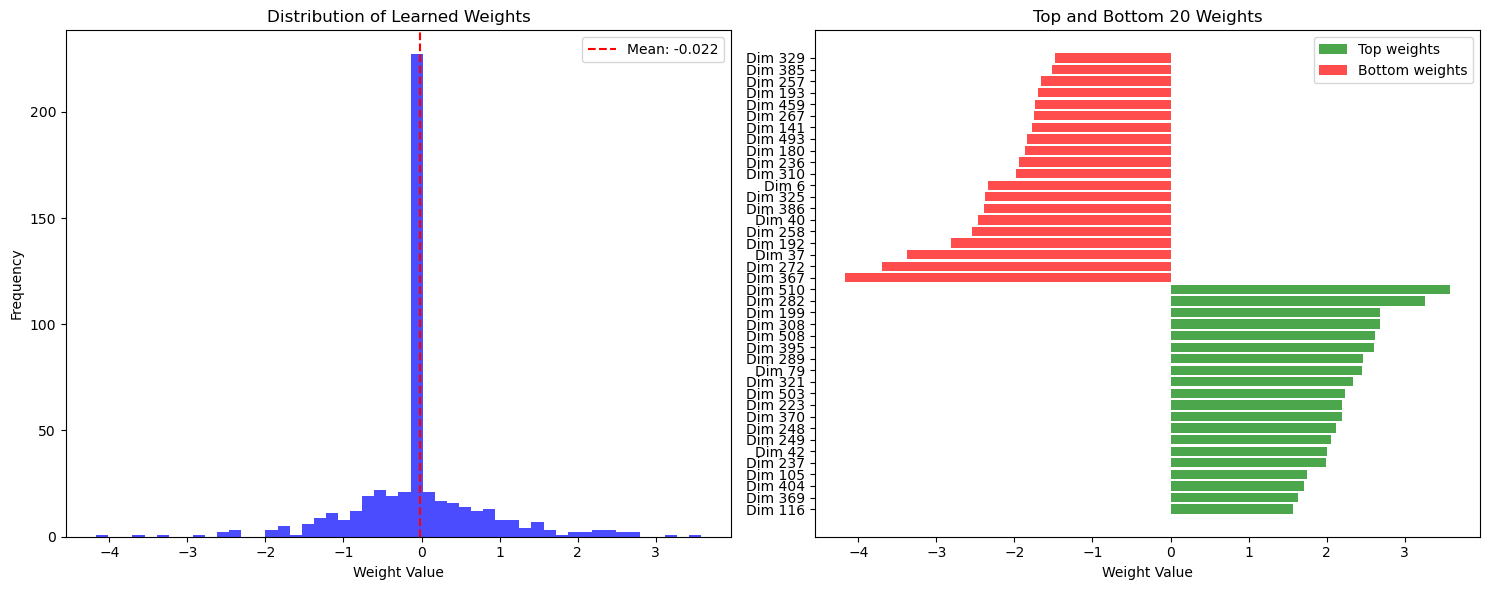


Weight Statistics:
Mean: -0.0224
Std: 0.8450
Min: -4.1697 (Dimension 367)
Max: 3.5783 (Dimension 116)

Number of weights > 1: 44
Number of weights < 1: 468


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")
print(f"\nNumber of weights > 1: {np.sum(learned_weights > 1)}")
print(f"Number of weights < 1: {np.sum(learned_weights < 1)}")

In [81]:
np.save('learned_cosine_weights.npy', learned_weights)